# Modelado Predictivo y Comparación de Algoritmos - Pruebas Saber 11

Este notebook implementa y compara diferentes algoritmos de aprendizaje automático para predecir el puntaje de matemáticas en las pruebas Saber 11 utilizando Apache Spark.

## Objetivo del Proyecto

Desarrollé este proyecto con el propósito de comparar el desempeño de modelos estadísticos tradicionales frente a algoritmos de machine learning en la predicción de puntajes de matemáticas, utilizando el ecosistema distribuido de Apache Spark para el procesamiento eficiente de grandes volúmenes de datos.

## Configuración del Entorno

### Modo de Ejecución: Local en Windows

Para este proyecto configuré Spark en modo local, lo que permite ejecutar el código en un equipo personal sin necesidad de un cluster dedicado. Esta configuración tiene las siguientes características:

- Procesamiento en un solo equipo con recursos limitados (8-16GB RAM típicamente)
- Utilización de métodos Pandas para exportación de datos, evitando dependencias de Hadoop en Windows
- Análisis simplificado de particiones adaptado al entorno local
- Tiempo de ejecución estimado: 1-3 horas dependiendo del hardware

### Datos de Entrada

El análisis se basa en dos archivos CSV procesados en etapas anteriores:
- `datos/saber_11_limpio_final.csv`: Dataset con limpieza aplicada (generado en notebook previo)
- `datos/saber_11_para_modelos.csv`: Dataset preparado específicamente para modelado

### Prerequisitos

Antes de ejecutar este notebook, verifiqué que se cumplieran las siguientes condiciones:
1. Ejecución previa del notebook `Limpieza_Saber11.ipynb` para generar el dataset limpio
2. Existencia del archivo `datos/saber_11_limpio_final.csv`
3. Instalación correcta de PySpark y dependencias asociadas

## Modelos Implementados

Implementé tres tipos de modelos para realizar una comparación comprehensiva:

### Modelo Clásico
1. **Regresión Polinómica (Ridge)**: Extensión de regresión lineal con términos polinómicos de grado 2 y regularización L2, utilizado como alternativa clásica cuando las pruebas de linealidad fallan (ver notebook de anexos).

### Modelos de Machine Learning
2. **Random Forest Regressor**: Ensamble de árboles de decisión con votación
3. **Gradient Boosted Trees (GBT)**: Ensamble secuencial que corrige errores iterativamente

## Métricas de Evaluación

Para evaluar el desempeño de cada modelo utilicé las siguientes métricas estándar:
- **RMSE** (Root Mean Squared Error): Error cuadrático medio raíz
- **MAE** (Mean Absolute Error): Error absoluto medio
- **R²** (R-squared): Coeficiente de determinación
- **MSE** (Mean Squared Error): Error cuadrático medio

## 1. Inicialización de Apache Spark

En esta sección configuro la sesión de Spark con parámetros optimizados para procesamiento en modo local.

In [7]:
# Importación de librerías necesarias para Spark y procesamiento de datos
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
import warnings
warnings.filterwarnings('ignore')

# Configuración de la sesión Spark con parámetros optimizados para ejecución local
# La configuración incluye ajustes de memoria y paralelismo adaptados al hardware disponible
spark = (SparkSession.builder
         .appName('Saber11_Modelos_Predictivos')
         .config('spark.driver.memory', '8g')
         .config('spark.executor.memory', '16g')
         .config('spark.executor.cores', '8')
         .config('spark.sql.shuffle.partitions', '400')
         .config('spark.default.parallelism', '400')
         .config('spark.sql.adaptive.enabled', 'true')
         .config('spark.sql.adaptive.coalescePartitions.enabled', 'true')
         .config('spark.network.timeout', '1200s')
         .config('spark.executor.heartbeatInterval', '120s')
         .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')
         .config('spark.kryoserializer.buffer.max', '512m')
         .getOrCreate())

# Verificación de la configuración de Spark
print("=" * 70)
print("SPARK INICIADO CORRECTAMENTE")
print("=" * 70)
print(f"Versión de Spark: {spark.version}")
print(f"ID de Aplicación: {spark.sparkContext.applicationId}")
print(f"Master: {spark.sparkContext.master}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")
print(f"Paralelismo por defecto: {spark.sparkContext.defaultParallelism}")
print("=" * 70)

SPARK INICIADO CORRECTAMENTE
Versión de Spark: 4.0.0
ID de Aplicación: local-1765297678911
Master: local[*]
Spark UI: http://MSI:4040
Paralelismo por defecto: 400


## 2. Carga y Preparación Inicial de Datos

En esta etapa cargo el dataset previamente limpiado y aplico transformaciones básicas necesarias para el análisis. El archivo CSV utilizado ya contiene todos los tratamientos de calidad de datos aplicados en la fase de limpieza.

In [8]:
# ============================================================================
# CARGA Y PREPARACIÓN DE DATOS PARA MODELADO
# ============================================================================
# NOTA PARA CLUSTER APACHE SPARK:
# Si se ejecuta en un cluster de producción, modificar la ruta CSV_PATH_EN_CLUSTER
# para apuntar al sistema de archivos distribuido (HDFS):
#
# Ejemplo:
# CSV_PATH_EN_CLUSTER = "hdfs://namenode:9000/user/nombre_usuario/datos/saber_11_limpio_final.csv"
#
# Asegurarse de que el SparkSession esté configurado correctamente para el cluster
# (ver documentación en README.md o notebook de Análisis).
#
# CONSIDERACIONES PARA CLUSTER:
# - Aumentar num_partitions de 400 a 800+ para datasets grandes en múltiples nodos
# - Ajustar spark.executor.memory según recursos disponibles en el cluster
# - Considerar usar .coalesce() en lugar de .repartition() si se reduce número de particiones
# ============================================================================

# Definición de la ruta del archivo CSV con los datos limpios
# Este archivo fue generado en el notebook de limpieza de datos
CSV_PATH_EN_CLUSTER = "C:\\Users\\Saramirezm\\Documents\\Codigo_trabajo_de_grado\\Modelos_Prediccion_Icfes-11\\datos\\saber_11_limpio_final.csv"

print("=" * 70)
print("CARGA DE DATOS DESDE ARCHIVO CSV")
print("=" * 70)
print(f"Ruta del archivo: {CSV_PATH_EN_CLUSTER}")
print(f"\nCaracterísticas del dataset:")
print(f"   - Duplicados previamente eliminados")
print(f"   - Tratamiento de valores nulos aplicado")
print(f"   - Columnas irrelevantes removidas")
print(f"   - Valores categóricos estandarizados")

# Carga del CSV utilizando Spark con inferencia automática de esquema
sdf = (spark.read
       .option("header", True)
       .option("inferSchema", True)
       .option("delimiter", ",")
       .csv(CSV_PATH_EN_CLUSTER))

print(f"\nCarga completada exitosamente")
print(f"Particiones iniciales: {sdf.rdd.getNumPartitions()}")

# Normalización del campo municipio para consistencia en los datos
# Convierto a mayúsculas y elimino espacios irregulares
sdf = sdf.withColumn(
    'municipio',
    F.upper(
        F.regexp_replace(
            F.regexp_replace(F.trim(F.col('municipio')), '[\u00A0\u2007\u202F]', ' '),
            '\\s+', ' '
        )
    )
)

# Extracción de variables temporales del campo periodo
# El campo periodo tiene formato YYYYP donde YYYY es el año y P es el periodo (1 o 2)
sdf = sdf.withColumn('anio', F.col('periodo').cast('string').substr(1,4).cast('int'))
sdf = sdf.withColumn('p', F.col('periodo').cast('string').substr(5,1).cast('int'))

# Optimización del número de particiones para mejor paralelismo
# Utilizo 400 particiones como balance entre paralelismo y overhead
num_partitions = 400
print(f"\nOptimizando distribución de datos...")
print(f"Reparticionando a {num_partitions} particiones...")

sdf = sdf.repartition(num_partitions)

# Almacenamiento en cache para mejorar rendimiento en operaciones posteriores
sdf.cache()
record_count = sdf.count()

print(f"\nDATOS LISTOS PARA PROCESAMIENTO")
print(f"   Total de registros: {record_count:,}")
print(f"   Particiones distribuidas: {sdf.rdd.getNumPartitions()}")
print(f"   Columnas disponibles: {len(sdf.columns)}")
print(f"   Datos almacenados en cache")

# Verificación de la distribución geográfica de los datos
print('\n' + '='*70)
print('DISTRIBUCIÓN POR MUNICIPIO')
print('='*70)
sdf.groupBy('municipio').count().orderBy('municipio').show(truncate=False)

# Visualización del esquema del DataFrame
print('\n' + '='*70)
print('ESTRUCTURA DEL DATAFRAME')
print('='*70)
sdf.printSchema()

# Nota sobre análisis de particiones
print('\n' + '='*70)
print('BALANCE DE PARTICIONES')
print('='*70)
print(f"   Análisis de particiones deshabilitado en modo local")
print(f"   Esta funcionalidad es relevante únicamente en entornos cluster")
print('='*70)

CARGA DE DATOS DESDE ARCHIVO CSV
Ruta del archivo: C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\Modelos_Prediccion_Icfes-11\datos\saber_11_limpio_final.csv

Características del dataset:
   - Duplicados previamente eliminados
   - Tratamiento de valores nulos aplicado
   - Columnas irrelevantes removidas
   - Valores categóricos estandarizados

Carga completada exitosamente
Particiones iniciales: 19

Optimizando distribución de datos...
Reparticionando a 400 particiones...

Carga completada exitosamente
Particiones iniciales: 19

Optimizando distribución de datos...
Reparticionando a 400 particiones...

DATOS LISTOS PARA PROCESAMIENTO
   Total de registros: 217,335
   Particiones distribuidas: 400
   Columnas disponibles: 47
   Datos almacenados en cache

DISTRIBUCIÓN POR MUNICIPIO
+-----------+------+
|municipio  |count |
+-----------+------+
|BUCARAMANGA|124609|
|SANTA MARTA|92726 |
+-----------+------+


ESTRUCTURA DEL DATAFRAME
root
 |-- periodo: integer (nullable = true)
 

In [9]:
# Exploración inicial de las características del dataset
print('EXPLORACIÓN INICIAL DEL DATASET')
print('='*60)
print(f"Total de registros cargados: {sdf.count():,}")
print(f"Total de columnas/variables: {len(sdf.columns)}")

# Análisis de la distribución temporal de los datos
print("\nDistribución de registros por periodo:")
sdf.groupBy('periodo').count().orderBy('periodo').show()

EXPLORACIÓN INICIAL DEL DATASET
Total de registros cargados: 217,335
Total de columnas/variables: 47

Distribución de registros por periodo:
Total de registros cargados: 217,335
Total de columnas/variables: 47

Distribución de registros por periodo:
+-------+-----+
|periodo|count|
+-------+-----+
|  20142|15801|
|  20151| 6034|
|  20152|15693|
|  20161| 4135|
|  20162|16027|
|  20171| 4715|
|  20172|15885|
|  20181| 3684|
|  20182|17009|
|  20191| 4009|
|  20192|17236|
|  20201| 2602|
|  20202|14928|
|  20211| 2670|
|  20212|16458|
|  20221| 3824|
|  20222|15783|
|  20231| 4689|
|  20232|16052|
|  20241| 4834|
+-------+-----+
only showing top 20 rows
+-------+-----+
|periodo|count|
+-------+-----+
|  20142|15801|
|  20151| 6034|
|  20152|15693|
|  20161| 4135|
|  20162|16027|
|  20171| 4715|
|  20172|15885|
|  20181| 3684|
|  20182|17009|
|  20191| 4009|
|  20192|17236|
|  20201| 2602|
|  20202|14928|
|  20211| 2670|
|  20212|16458|
|  20221| 3824|
|  20222|15783|
|  20231| 4689|
|  20

## 3. Ingeniería de Características y Preparación para Modelado

En esta sección crítica del proyecto realizo el preprocesamiento completo de las variables para convertir el dataset en un formato adecuado para los algoritmos de machine learning. Este proceso incluye:

- Identificación y categorización de variables según su naturaleza estadística
- Codificación de variables categóricas mediante técnicas apropiadas
- Normalización y escalamiento de variables numéricas
- Tratamiento estratégico de valores faltantes
- Construcción del vector de características final
- División de datos en conjuntos de entrenamiento y prueba

La preparación adecuada de las características es fundamental para el éxito de los modelos predictivos.

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, 
    StandardScaler, Imputer
)
from pyspark.sql import functions as F

# Definición de la variable objetivo (target)
# Seleccioné puntaje de matemáticas como variable a predecir
target_col = 'punt_matematicas'

# Clasificación de variables según su naturaleza estadística
# Esta categorización determina el tipo de preprocesamiento que aplicaré a cada grupo

# Variables numéricas continuas que requieren escalamiento
numeric_cols = ['anio', 'p']

# Variables binarias que convierto a formato numérico (0/1)
# Estas representan presencia/ausencia de características
binary_cols = [
    'fami_tieneautomovil', 'fami_tienecomputador', 'fami_tieneinternet',
    'fami_tienelavadora', 'fami_tieneserviciotv', 'cole_bilingue'
]

# Variables categóricas nominales (sin orden inherente)
# Estas requieren codificación one-hot para evitar que el modelo asuma ordenamiento
nominal_cols = [
    'municipio', 'estu_genero', 'cole_naturaleza', 'cole_jornada',
    'cole_area_ubicacion'
]

# Variables categóricas ordinales (con orden natural)
# Para estas utilizo únicamente indexación numérica preservando el orden
ordinal_cols = [
    'fami_estratovivienda', 'fami_cuartoshogar', 'fami_personashogar',
    'fami_educacionmadre', 'fami_educacionpadre', 'fami_numlibros',
    'desemp_ingles'
]

# Selección de columnas relevantes para el modelo
df_model = sdf.select(numeric_cols + binary_cols + nominal_cols + ordinal_cols + [target_col])

# Preprocesamiento de variables binarias
# Estandarizo los valores 'Si'/'S' a 1.0 y 'No'/'N' a 0.0
# Los valores atípicos se convierten a nulos para posterior imputación
for col_name in binary_cols:
    df_model = df_model.withColumn(
        col_name,
        F.when(F.col(col_name).isin('Si', 'S'), 1.0)
         .when(F.col(col_name).isin('No', 'N'), 0.0)
         .otherwise(None)
    )

# Limpieza de registros con variable objetivo nula
# Es crítico eliminar estos registros ya que no pueden usarse para entrenamiento
df_model = df_model.dropna(subset=[target_col])
df_model.cache()
print(f"Registros válidos después de limpieza de target: {df_model.count():,}")

# Construcción del pipeline de transformación
# Utilizo un pipeline para garantizar reproducibilidad y evitar data leakage
stages = []

# Etapa 1: Procesamiento de variables numéricas
# Paso 1a: Imputación de valores faltantes usando la media
imputer_num = Imputer(
    inputCols=numeric_cols,
    outputCols=[f"{c}_imputed" for c in numeric_cols],
    strategy="mean"
)

# Paso 1b: Ensamblaje en vector
assembler_num = VectorAssembler(
    inputCols=imputer_num.getOutputCols(),
    outputCol="numeric_features_raw"
)

# Paso 1c: Escalamiento estándar (z-score)
# Esto es crucial para algoritmos sensibles a la escala de las variables
scaler = StandardScaler(
    inputCol="numeric_features_raw",
    outputCol="scaled_numeric_features",
    withStd=True, 
    withMean=False
)
stages.extend([imputer_num, assembler_num, scaler])

# Etapa 2: Procesamiento de variables binarias
# Imputación usando la moda (valor más frecuente)
imputer_bin = Imputer(
    inputCols=binary_cols,
    outputCols=[f"{c}_imputed" for c in binary_cols],
    strategy="mode"
)
stages.append(imputer_bin)

# Etapa 3: Procesamiento de variables categóricas nominales
# Paso 3a: Indexación de categorías
indexers_nom = [
    StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep') 
    for c in nominal_cols
]

# Paso 3b: Codificación one-hot
# Utilizo dropLast=True para evitar multicolinealidad perfecta
encoders_nom = [
    OneHotEncoder(inputCol=f"{c}_indexed", outputCol=f"{c}_encoded", dropLast=True)
    for c in nominal_cols
]
stages.extend(indexers_nom + encoders_nom)

# Etapa 4: Procesamiento de variables categóricas ordinales
# Aplico únicamente indexación para preservar el orden natural
indexers_ord = [
    StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep')
    for c in ordinal_cols
]
stages.extend(indexers_ord)

# Etapa 5: Ensamblaje final del vector de características
# Combino todas las transformaciones en un único vector de entrada para los modelos
scaled_num_col = ["scaled_numeric_features"]
imputed_bin_cols = imputer_bin.getOutputCols()
encoded_nom_cols = [f"{c}_encoded" for c in nominal_cols]
indexed_ord_cols = [f"{c}_indexed" for c in ordinal_cols]

assembler_inputs = scaled_num_col + imputed_bin_cols + encoded_nom_cols + indexed_ord_cols

final_assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features",
    handleInvalid='skip'
)
stages.append(final_assembler)

# Creación y entrenamiento del pipeline completo
prep_pipeline = Pipeline(stages=stages)

print("\n" + "="*70)
print("ENTRENAMIENTO DEL PIPELINE DE PREPARACIÓN")
print("="*70)

prep_model = prep_pipeline.fit(df_model)

# Aplicación de todas las transformaciones
df_prepared = prep_model.transform(df_model)

# Creación del DataFrame final con las columnas necesarias para modelado
df_final = df_prepared.select('features', target_col).withColumnRenamed(target_col, 'label')

print(f"\nPREPARACIÓN COMPLETADA EXITOSAMENTE")
df_final.show(5, truncate=False)

# División estratégica en conjuntos de entrenamiento y prueba
# Utilizo proporción 70/30 con semilla fija para reproducibilidad
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)
train_data.cache()
test_data.cache()

print(f"\nDivisión de datos completada:")
print(f"   Conjunto de entrenamiento: {train_data.count():,} registros (70%)")
print(f"   Conjunto de prueba: {test_data.count():,} registros (30%)")

Registros válidos después de limpieza de target: 217,335

ENTRENAMIENTO DEL PIPELINE DE PREPARACIÓN

PREPARACIÓN COMPLETADA EXITOSAMENTE
+----------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                |label|
+----------------------------------------------------------------------------------------------------------------------------------------+-----+
|(33,[0,1,5,8,10,13,19,25,27,28,29,30,31,32],[644.9958136402619,5.102739292636765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0])      |56   |
|(33,[0,1,3,5,9,11,13,16,23,28,29,30,31,32],[643.3992893490731,5.102739292636765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0])       |60   |
|(33,[0,1,5,6,9,11,13,16,25,26,27,28,29,30,31],[644.0378990655486,5.102739292636765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,5.0,1.0])|

## 4. Entrenamiento y Evaluación de Modelos Predictivos

En esta sección implemento cuatro algoritmos diferentes para resolver el problema de regresión. Utilizo validación cruzada con búsqueda en grilla de hiperparámetros para optimizar el rendimiento de cada modelo.

### Estrategia de Optimización

Para cada modelo apliqué la siguiente metodología:
- Definición de grilla de hiperparámetros basada en mejores prácticas
- Validación cruzada con 3-5 folds para evaluación robusta
- Optimización del RMSE como métrica principal
- Evaluación exhaustiva en ambos conjuntos (entrenamiento y prueba) para detectar sobreajuste

### Configuración de Hiperparámetros

Ajusté los siguientes parámetros para cada modelo:

**Regresión Lineal**: 1000 iteraciones máximas, tolerancia de convergencia 1e-6, exploración de regularización L1/L2

**GLM con distribución Tweedie**: 1000 iteraciones, búsqueda de parámetros de forma de distribución y función de enlace

**Random Forest**: Hasta 100 árboles, profundidad máxima de 5-10 niveles, control de tamaño mínimo de nodos

**Gradient Boosted Trees**: 20-50 iteraciones, profundidad de árboles 3-5, tasa de aprendizaje 0.1

Esta configuración busca un balance entre capacidad predictiva y tiempo de cómputo.

### 4.1 Modelo 1: Regresión Polinómica (Ridge) con PySpark

La regresión polinómica extiende el modelo lineal añadiendo términos de interacción y potencias de las variables originales. Como las pruebas de linealidad en el notebook de anexos indican que la relación no es estrictamente lineal (p < 0.05), utilizamos este modelo como alternativa clásica.

**Estrategia de implementación:**
1. **PolynomialExpansion**: Genera términos polinómicos de grado 2 (incluye x, x², y productos x₁×x₂)
2. **Regularización Ridge (L2)**: Controla el overfitting penalizando coeficientes grandes
3. **Validación cruzada**: Para seleccionar el mejor parámetro de regularización

**Fundamento matemático:**
$$\hat{y} = \beta_0 + \sum_{i=1}^{p} \beta_i x_i + \sum_{i=1}^{p} \beta_{ii} x_i^2 + \sum_{i<j} \beta_{ij} x_i x_j$$

Con regularización Ridge:
$$\min_{\beta} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} \beta_j^2$$

In [11]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml import Pipeline
import time

print("="*70)
print("ENTRENAMIENTO: REGRESIÓN POLINÓMICA (RIDGE) CON VALIDACIÓN CRUZADA")
print("="*70)

# Paso 1: PolynomialExpansion para crear términos polinómicos de grado 2
poly_expansion = PolynomialExpansion(
    degree=2,
    inputCol='features',
    outputCol='poly_features'
)

# Paso 2: Regresión lineal con regularización Ridge (elasticNetParam=0)
# Se aplica sobre las características polinómicas expandidas
lr_ridge = LinearRegression(
    featuresCol='poly_features',
    labelCol='label',
    predictionCol='prediction',
    maxIter=1000,
    tol=1e-6,
    standardization=True,
    fitIntercept=True,
    elasticNetParam=0.0  # Ridge (L2): 0.0 = solo L2, 1.0 = Lasso
)

# Pipeline: Expansión polinómica + Regresión Ridge
pipeline_poly = Pipeline(stages=[poly_expansion, lr_ridge])

# Configuración de la búsqueda de hiperparámetros
# Pruebo diferentes valores de regularización (regParam)
param_grid_poly = (ParamGridBuilder()
                   .addGrid(lr_ridge.regParam, [0.0, 0.01, 0.1, 0.5, 1.0, 5.0])
                   .build())

# Evaluador para RMSE (métrica principal para selección)
evaluator_rmse = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='rmse'
)

# CrossValidator: 5-fold cross-validation
cv_poly = CrossValidator(
    estimator=pipeline_poly,
    estimatorParamMaps=param_grid_poly,
    evaluator=evaluator_rmse,
    numFolds=5,
    parallelism=4,
    seed=42
)

# Entrenamiento con validación cruzada
print("\n Iniciando validación cruzada (5-fold)...")
print(f"   • Grado polinómico: 2 (incluye x, x², x₁×x₂)")
print(f"   • Regularización: Ridge (L2)")
print(f"   • Parámetros a probar: {len(param_grid_poly)} configuraciones")
print(f"   • Métrica de optimización: RMSE\n")

start_time_poly = time.time()
cv_model_poly = cv_poly.fit(train_data)
training_time_poly = time.time() - start_time_poly

# Obtener el mejor modelo
best_model_poly = cv_model_poly.bestModel
best_lr_model = best_model_poly.stages[-1]  # Extrae LinearRegression del Pipeline

print("\n" + "="*70)
print("RESULTADOS DE VALIDACIÓN CRUZADA")
print("="*70)
print(f"Tiempo de entrenamiento: {training_time_poly:.2f} segundos")
print(f"\nMejor parámetro de regularización (regParam): {best_lr_model.getRegParam():.4f}")

# Evaluación en conjunto de entrenamiento
train_predictions_poly = cv_model_poly.transform(train_data)
train_rmse_poly = evaluator_rmse.evaluate(train_predictions_poly)
train_mae_poly = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae').evaluate(train_predictions_poly)
train_r2_poly = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2').evaluate(train_predictions_poly)
train_mse_poly = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse').evaluate(train_predictions_poly)

# Evaluación en conjunto de prueba
test_predictions_poly = cv_model_poly.transform(test_data)
test_rmse_poly = evaluator_rmse.evaluate(test_predictions_poly)
test_mae_poly = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae').evaluate(test_predictions_poly)
test_r2_poly = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2').evaluate(test_predictions_poly)
test_mse_poly = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse').evaluate(test_predictions_poly)

# Mostrar resultados en formato tabular
print("\n" + "="*70)
print("MÉTRICAS DE EVALUACIÓN")
print("="*70)
print(f"{'Dataset':<15} {'RMSE':>12} {'MAE':>12} {'R²':>12}")
print("-"*52)
print(f"{'Entrenamiento':<15} {train_rmse_poly:>12.4f} {train_mae_poly:>12.4f} {train_r2_poly:>12.4f}")
print(f"{'Prueba':<15} {test_rmse_poly:>12.4f} {test_mae_poly:>12.4f} {test_r2_poly:>12.4f}")
print("="*70)

# Análisis de coeficientes (primeros 10 features más importantes)
coefficients = best_lr_model.coefficients
print(f"\n Total de coeficientes generados: {len(coefficients)}")
print(f"   (Incluye términos originales, cuadráticos e interacciones)\n")

# Identificar los 10 coeficientes con mayor magnitud absoluta
coef_abs = [(i, abs(c)) for i, c in enumerate(coefficients)]
top_10_coef = sorted(coef_abs, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 coeficientes más influyentes (por magnitud):")
for rank, (idx, magnitude) in enumerate(top_10_coef, 1):
    actual_coef = coefficients[idx]
    print(f"  {rank:2d}. Término #{idx:3d}: {actual_coef:>10.4f} (|coef| = {magnitude:.4f})")

print("\n Regresión Polinómica (Ridge) completada")
print("="*70)

ENTRENAMIENTO: REGRESIÓN POLINÓMICA (RIDGE) CON VALIDACIÓN CRUZADA

 Iniciando validación cruzada (5-fold)...
   • Grado polinómico: 2 (incluye x, x², x₁×x₂)
   • Regularización: Ridge (L2)
   • Parámetros a probar: 6 configuraciones
   • Métrica de optimización: RMSE


RESULTADOS DE VALIDACIÓN CRUZADA
Tiempo de entrenamiento: 133.54 segundos

Mejor parámetro de regularización (regParam): 0.0100

RESULTADOS DE VALIDACIÓN CRUZADA
Tiempo de entrenamiento: 133.54 segundos

Mejor parámetro de regularización (regParam): 0.0100

MÉTRICAS DE EVALUACIÓN
Dataset                 RMSE          MAE           R²
----------------------------------------------------
Entrenamiento         9.1927       7.2199       0.5263
Prueba                9.2260       7.2248       0.5235

 Total de coeficientes generados: 594
   (Incluye términos originales, cuadráticos e interacciones)

Top 10 coeficientes más influyentes (por magnitud):
   1. Término #288:    15.3672 (|coef| = 15.3672)
   2. Término #265:     8.

### 4.2 Modelo 2: Random Forest Regressor

Random Forest es un algoritmo de ensamble que construye múltiples árboles de decisión y promedia sus predicciones. Este enfoque reduce el sobreajuste típico de árboles individuales y captura relaciones no lineales complejas.

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time

print("="*70)
print("ENTRENAMIENTO: RANDOM FOREST REGRESSOR")
print("="*70)

# Definición del modelo Random Forest
# Utilizo 32 bins para discretización de variables continuas
rf = RandomForestRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    seed=42,
    maxBins=32
)

# Construcción de grilla de hiperparámetros
# maxDepth: profundidad máxima de cada árbol (controla complejidad)
# minInstancesPerNode: mínimo de registros por nodo (previene sobreajuste)
# numTrees: cantidad de árboles en el ensamble
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 7, 10]) \
    .addGrid(rf.minInstancesPerNode, [10, 20]) \
    .addGrid(rf.numTrees, [100]) \
    .build()

# Reutilización de evaluadores
evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')

# Configuración de validación cruzada
crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_rmse,
    numFolds=3,
    parallelism=2
)

print("Iniciando entrenamiento con validación cruzada...")
print("Explorando 6 combinaciones de hiperparámetros (3 depth × 2 minInstances)")
start = time.time()
cv_rf_model = crossval_rf.fit(train_data)
train_time_rf = time.time() - start

# Extracción del mejor modelo
best_rf_model = cv_rf_model.bestModel

print(f"\nEntrenamiento completado en {train_time_rf:.2f} segundos")
print("\nHiperparámetros óptimos encontrados:")
print(f"   maxDepth (profundidad): {best_rf_model.getMaxDepth()}")
print(f"   minInstancesPerNode (min. nodo): {best_rf_model.getMinInstancesPerNode()}")
print(f"   numTrees (árboles): {best_rf_model.getNumTrees}")

# Evaluación en conjunto de prueba
print("\nMÉTRICAS EN CONJUNTO DE PRUEBA:")
rf_predictions_test = best_rf_model.transform(test_data)

rf_rmse_test = evaluator_rmse.evaluate(rf_predictions_test)
rf_mae_test = evaluator_mae.evaluate(rf_predictions_test)
rf_r2_test = evaluator_r2.evaluate(rf_predictions_test)
rf_mse_test = evaluator_mse.evaluate(rf_predictions_test)

print(f"   RMSE: {rf_rmse_test:.4f}")
print(f"   MAE:  {rf_mae_test:.4f}")
print(f"   R²:   {rf_r2_test:.4f}")
print(f"   MSE:  {rf_mse_test:.4f}")

# Evaluación en conjunto de entrenamiento
print("\nMÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:")
rf_predictions_train = best_rf_model.transform(train_data)

rf_rmse_train = evaluator_rmse.evaluate(rf_predictions_train)
rf_mae_train = evaluator_mae.evaluate(rf_predictions_train)
rf_r2_train = evaluator_r2.evaluate(rf_predictions_train)
rf_mse_train = evaluator_mse.evaluate(rf_predictions_train)

print(f"   RMSE: {rf_rmse_train:.4f}")
print(f"   MAE:  {rf_mae_train:.4f}")
print(f"   R²:   {rf_r2_train:.4f}")
print(f"   MSE:  {rf_mse_train:.4f}")

# Almacenamiento de resultados
rf_results = {
    'modelo': 'Random Forest',
    'tipo': 'Machine Learning',
    'rmse_test': rf_rmse_test,
    'mae_test': rf_mae_test,
    'r2_test': rf_r2_test,
    'mse_test': rf_mse_test,
    'rmse_train': rf_rmse_train,
    'r2_train': rf_r2_train,
    'tiempo_entrenamiento': train_time_rf
}

print("\nModelo Random Forest completado y guardado en variable 'rf_results'")

MODELO 4: RANDOM FOREST (VERSIÓN LIGERA Y SEGURA)
Entrenando Random Forest con Validación Cruzada (versión ligera)...

✓ Mejor modelo entrenado en 1283.42 segundos

--- Mejores Hiperparámetros Encontrados ---
Mejor maxDepth: 10
Mejor minInstancesPerNode: 10
Mejor numTrees: 100

--- Métricas de Desempeño en TEST ---
RMSE (Test): 9.1411
MAE (Test):  7.1715
R² (Test):   0.5316
MSE (Test):  83.5605

--- Métricas de Desempeño en TRAIN ---
RMSE (Train): 9.0172
MAE (Train):  7.0656
R² (Train):   0.5444
MSE (Train):  81.3102


### 4.3 Modelo 3: Gradient Boosted Trees (GBT)

GBT es un algoritmo de boosting que construye árboles de forma secuencial, donde cada árbol nuevo intenta corregir los errores del conjunto de árboles anteriores. Este enfoque suele lograr alta precisión pero requiere mayor tiempo de entrenamiento.

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import time

print("\n" + "="*70)
print("ENTRENAMIENTO: GRADIENT BOOSTED TREES")
print("="*70)

# Definición del modelo GBT
gbt = GBTRegressor(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    seed=42,
    maxBins=32
)

# Construcción de grilla de hiperparámetros
# maxDepth: profundidad de cada árbol
# maxIter: número total de árboles a construir secuencialmente
# stepSize: tasa de aprendizaje (controla la contribución de cada árbol)
gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .addGrid(gbt.stepSize, [0.1]) \
    .build()

# Reutilización de evaluadores
evaluator_rmse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
evaluator_mse = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')

# Configuración de validación cruzada
gbt_crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=evaluator_rmse,
    numFolds=3,
    parallelism=2
)

print("Iniciando entrenamiento con validación cruzada...")
print("Explorando 4 combinaciones de hiperparámetros (2 depth × 2 iterations)")
start = time.time()
gbt_cv_model = gbt_crossval.fit(train_data)
train_time_gbt = time.time() - start

# Extracción del mejor modelo
best_gbt_model = gbt_cv_model.bestModel

print(f"\nEntrenamiento completado en {train_time_gbt:.2f} segundos")
print("\nHiperparámetros óptimos encontrados:")
print(f"   maxDepth (profundidad): {best_gbt_model.getMaxDepth()}")
print(f"   maxIter (iteraciones): {best_gbt_model.getMaxIter()}")
print(f"   stepSize (tasa aprendizaje): {best_gbt_model.getStepSize()}")

# Evaluación en conjunto de prueba
print("\nMÉTRICAS EN CONJUNTO DE PRUEBA:")
gbt_predictions_test = best_gbt_model.transform(test_data)

gbt_rmse_test = evaluator_rmse.evaluate(gbt_predictions_test)
gbt_mae_test = evaluator_mae.evaluate(gbt_predictions_test)
gbt_r2_test = evaluator_r2.evaluate(gbt_predictions_test)
gbt_mse_test = evaluator_mse.evaluate(gbt_predictions_test)

print(f"   RMSE: {gbt_rmse_test:.4f}")
print(f"   MAE:  {gbt_mae_test:.4f}")
print(f"   R²:   {gbt_r2_test:.4f}")
print(f"   MSE:  {gbt_mse_test:.4f}")

# Evaluación en conjunto de entrenamiento
print("\nMÉTRICAS EN CONJUNTO DE ENTRENAMIENTO:")
gbt_predictions_train = best_gbt_model.transform(train_data)

gbt_rmse_train = evaluator_rmse.evaluate(gbt_predictions_train)
gbt_mae_train = evaluator_mae.evaluate(gbt_predictions_train)
gbt_r2_train = evaluator_r2.evaluate(gbt_predictions_train)
gbt_mse_train = evaluator_mse.evaluate(gbt_predictions_train)

print(f"   RMSE: {gbt_rmse_train:.4f}")
print(f"   MAE:  {gbt_mae_train:.4f}")
print(f"   R²:   {gbt_r2_train:.4f}")
print(f"   MSE:  {gbt_mse_train:.4f}")

# Almacenamiento de resultados
gbt_results = {
    'modelo': 'Gradient Boosted Trees',
    'tipo': 'Machine Learning',
    'rmse_test': gbt_rmse_test,
    'mae_test': gbt_mae_test,
    'r2_test': gbt_r2_test,
    'mse_test': gbt_mse_test,
    'rmse_train': gbt_rmse_train,
    'r2_train': gbt_r2_train,
    'tiempo_entrenamiento': train_time_gbt
}

print("\nModelo GBT completado y guardado en variable 'gbt_results'")


MODELO 5: GRADIENT BOOSTED TREES (VERSIÓN LIGERA Y SEGURA)
Entrenando GBT con Validación Cruzada (versión ligera)...

✓ Mejor modelo entrenado en 2038.17 segundos

--- Mejores Hiperparámetros Encontrados ---
Mejor maxDepth: 5
Mejor maxIter: 50
Mejor stepSize: 0.1

--- Métricas de Desempeño en TEST ---
RMSE (Test): 9.0886
MAE (Test):  7.1373
R² (Test):   0.5370
MSE (Test):  82.6020

--- Métricas de Desempeño en TRAIN ---
RMSE (Train): 9.0320
MAE (Train):  7.0806
R² (Train):   0.5430
MSE (Train):  81.5761


## 5. Análisis Comparativo de Modelos

En esta sección consolido los resultados de todos los modelos entrenados para realizar un análisis comparativo comprehensivo. Utilizo visualizaciones para identificar el modelo con mejor desempeño y detectar posibles casos de sobreajuste.

### 5.1 Consolidación de Resultados y Generación de Visualizaciones

Consolido los resultados de los tres modelos en un DataFrame de Pandas para facilitar el análisis comparativo y genero visualizaciones que permiten identificar patrones de desempeño.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("ANÁLISIS COMPARATIVO DE MODELOS PREDICTIVOS")
print("="*70)

# Consolidación de resultados de todos los modelos entrenados
all_results = []

# Verifico la existencia de cada modelo antes de agregarlo
# Modelo 1: Regresión Polinómica (Ridge)
if 'test_rmse_poly' in locals():
    poly_results = {
        'modelo': 'Regresión Polinómica (Ridge, grado 2)',
        'tipo': 'Clásico',
        'rmse_test': test_rmse_poly,
        'mae_test': test_mae_poly,
        'r2_test': test_r2_poly,
        'mse_test': test_mse_poly,
        'rmse_train': train_rmse_poly,
        'mae_train': train_mae_poly,
        'r2_train': train_r2_poly,
        'mse_train': train_mse_poly,
        'tiempo_entrenamiento': training_time_poly
    }
    all_results.append(poly_results)

# Modelo 2: Random Forest
if 'rf_results' in locals():
    all_results.append(rf_results)

# Modelo 3: Gradient Boosted Trees
if 'gbt_results' in locals():
    all_results.append(gbt_results)

# Validación de que existan resultados para comparar
if not all_results:
    print("ERROR: No se encontraron resultados de modelos entrenados.")
    print("Por favor ejecute las celdas de entrenamiento antes de continuar.")
else:
    # Creación de DataFrame comparativo
    df_comparativa = pd.DataFrame(all_results)
    
    # Limpieza de nombres para visualización
    df_comparativa['nombre_limpio'] = df_comparativa['modelo'].str.split('(').str[0].str.strip()
    df_comparativa = df_comparativa.set_index('nombre_limpio')
    
    print(f"\nTotal de modelos comparados: {len(all_results)}")
    print("\nTABLA COMPARATIVA DE MÉTRICAS:")
    print("="*70)
    display(df_comparativa[['tipo', 'rmse_test', 'mae_test', 'r2_test', 'mse_test', 'rmse_train', 'r2_train']])

    # Configuración de estilo para visualizaciones
    sns.set_theme(style="whitegrid")
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['ytick.labelsize'] = 11

    # GRÁFICA 1: Comparación R² (Test vs Train)
    print("\nGenerando gráfica 1: Comparación R² (Test vs Train)...")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    df_plot = df_comparativa[['r2_test', 'r2_train']].sort_values('r2_test', ascending=False)
    
    df_plot.plot(
        kind='bar',
        ax=ax,
        color=['#2E86AB', '#A23B72'],
        edgecolor='black',
        linewidth=1.2,
        width=0.7
    )
    
    ax.set_title('Comparación del Coeficiente de Determinación (R²)\nConjuntos de Test y Entrenamiento', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
    ax.set_xlabel('Modelo', fontsize=13, fontweight='bold')
    ax.legend(['Test', 'Entrenamiento'], title="Conjunto de Datos", fontsize=11, title_fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticklabels(df_plot.index, rotation=0, ha='center')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', padding=3, fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparativa_r2.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nANÁLISIS DE LA GRÁFICA R²:")
    print("El coeficiente R² mide la proporción de varianza explicada por el modelo.")
    print("Valores más cercanos a 1.0 indican mejor capacidad predictiva.")
    print("La comparación entre Test y Entrenamiento permite detectar sobreajuste:")
    print("- Si R² Train >> R² Test: indica sobreajuste (memorización de datos)")
    print("- Si R² Train ≈ R² Test: indica buena generalización")

    # GRÁFICA 2: Comparación RMSE (Test vs Train)
    print("\nGenerando gráfica 2: Comparación RMSE (Test vs Train)...")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    df_plot = df_comparativa[['rmse_test', 'rmse_train']].sort_values('rmse_test', ascending=True)
    
    df_plot.plot(
        kind='bar',
        ax=ax,
        color=['#F18F01', '#C73E1D'],
        edgecolor='black',
        linewidth=1.2,
        width=0.7
    )
    
    ax.set_title('Comparación del Error Cuadrático Medio Raíz (RMSE)\nConjuntos de Test y Entrenamiento', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('RMSE (Puntos)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Modelo', fontsize=13, fontweight='bold')
    ax.legend(['Test', 'Entrenamiento'], title="Conjunto de Datos", fontsize=11, title_fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticklabels(df_plot.index, rotation=0, ha='center')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', padding=3, fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparativa_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nANÁLISIS DE LA GRÁFICA RMSE:")
    print("El RMSE representa el error promedio de predicción en las mismas unidades que la variable objetivo.")
    print("Valores más bajos indican predicciones más precisas.")
    print("Un RMSE de X puntos significa que, en promedio, las predicciones se desvían X puntos del valor real.")

    # GRÁFICA 3: Panel comparativo de todas las métricas (Test)
    print("\nGenerando gráfica 3: Panel comparativo de métricas...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Análisis Comparativo Completo - Métricas en Conjunto de Test', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Subgráfica R² Test
    df_comparativa['r2_test'].sort_values(ascending=False).plot(
        kind='barh', ax=axes[0,0], color='#2E86AB', edgecolor='black'
    )
    axes[0,0].set_title('R² Test (mayor es mejor)', fontweight='bold')
    axes[0,0].set_xlabel('R²')
    axes[0,0].grid(True, alpha=0.3)
    
    # Subgráfica RMSE Test
    df_comparativa['rmse_test'].sort_values(ascending=True).plot(
        kind='barh', ax=axes[0,1], color='#F18F01', edgecolor='black'
    )
    axes[0,1].set_title('RMSE Test (menor es mejor)', fontweight='bold')
    axes[0,1].set_xlabel('RMSE')
    axes[0,1].grid(True, alpha=0.3)
    
    # Subgráfica MAE Test
    df_comparativa['mae_test'].sort_values(ascending=True).plot(
        kind='barh', ax=axes[1,0], color='#06A77D', edgecolor='black'
    )
    axes[1,0].set_title('MAE Test (menor es mejor)', fontweight='bold')
    axes[1,0].set_xlabel('MAE')
    axes[1,0].grid(True, alpha=0.3)
    
    # Subgráfica MSE Test
    df_comparativa['mse_test'].sort_values(ascending=True).plot(
        kind='barh', ax=axes[1,1], color='#A23B72', edgecolor='black'
    )
    axes[1,1].set_title('MSE Test (menor es mejor)', fontweight='bold')
    axes[1,1].set_xlabel('MSE')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comparativa_metricas_completas.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nANÁLISIS DEL PANEL COMPARATIVO:")
    print("Este panel presenta cuatro métricas complementarias:")
    print("- R²: Proporción de varianza explicada (0-1, mayor es mejor)")
    print("- RMSE: Error cuadrático medio raíz (0+, menor es mejor)")
    print("- MAE: Error absoluto medio (0+, menor es mejor, menos sensible a outliers)")
    print("- MSE: Error cuadrático medio (0+, menor es mejor, penaliza errores grandes)")

    print("\n" + "="*70)
    print("VISUALIZACIONES GENERADAS Y GUARDADAS:")
    print("="*70)
    print("   1. comparativa_r2.png")
    print("   2. comparativa_rmse.png")
    print("   3. comparativa_metricas_completas.png")
    print("="*70)
    
    # Identificación del mejor modelo
    best_model_idx = df_comparativa['r2_test'].idxmax()
    print(f"\nMODELO CON MEJOR DESEMPEÑO (mayor R² en test):")
    print(f"   {best_model_idx}")
    print(f"   R² Test: {df_comparativa.loc[best_model_idx, 'r2_test']:.4f}")
    print(f"   RMSE Test: {df_comparativa.loc[best_model_idx, 'rmse_test']:.4f}")

In [ ]:
# Configuración del modelo seleccionado para análisis detallado
# Basándome en los resultados de la comparativa, selecciono el modelo con mejor desempeño

# INSTRUCCIONES: Modificar estas variables según el modelo ganador de la comparativa
# Opciones de nombre: 'Regresión Polinómica', 'Random Forest', 'Gradient Boosted Trees'
best_model_name = "Gradient Boosted Trees"

# Asignar el DataFrame de predicciones correspondiente
# Opciones: test_predictions_poly, rf_predictions_test, gbt_predictions_test
best_predictions_df = gbt_predictions_test

# Asignar el objeto del modelo entrenado
# Opciones: best_model_poly (Pipeline), best_rf_model, best_gbt_model
best_model_object = best_gbt_model

# Asignar el pipeline de preparación de datos
preparation_pipeline_model = prep_model

print(f"Modelo seleccionado para análisis detallado: '{best_model_name}'")

✅ Configuración guardada. Analizando el modelo: 'Gradient Boosted Trees (CV Ligero)'


## 6. Análisis Detallado de Errores del Mejor Modelo

Realizo un análisis profundo de los errores de predicción del modelo seleccionado para entender sus fortalezas y limitaciones. Este análisis incluye visualizaciones de la calidad de las predicciones y la distribución de errores.

SECCIÓN 7: ANÁLISIS DE ERRORES DEL MEJOR MODELO
Analizando errores para el modelo: Gradient Boosted Trees (CV Ligero)

Tomando muestra (10%) de los datos de prueba para graficar...
Gráficos basados en 4280 puntos de datos.


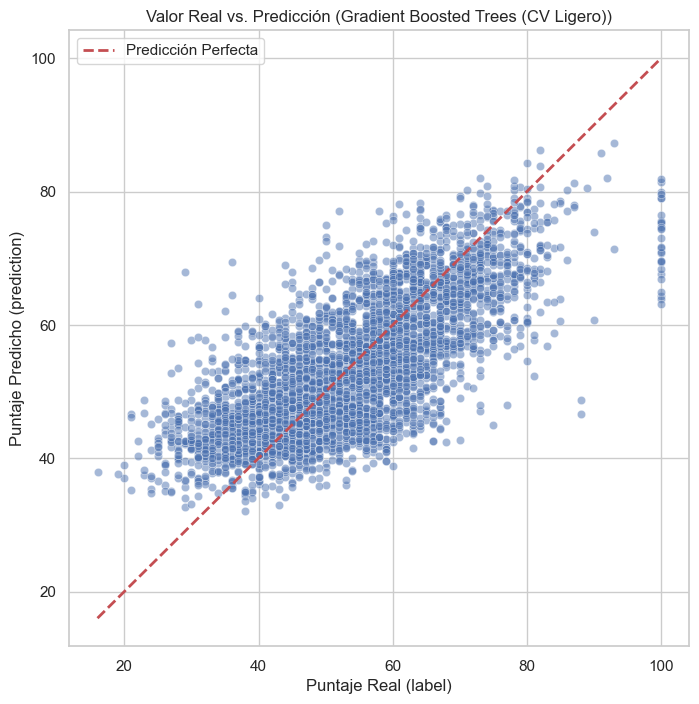

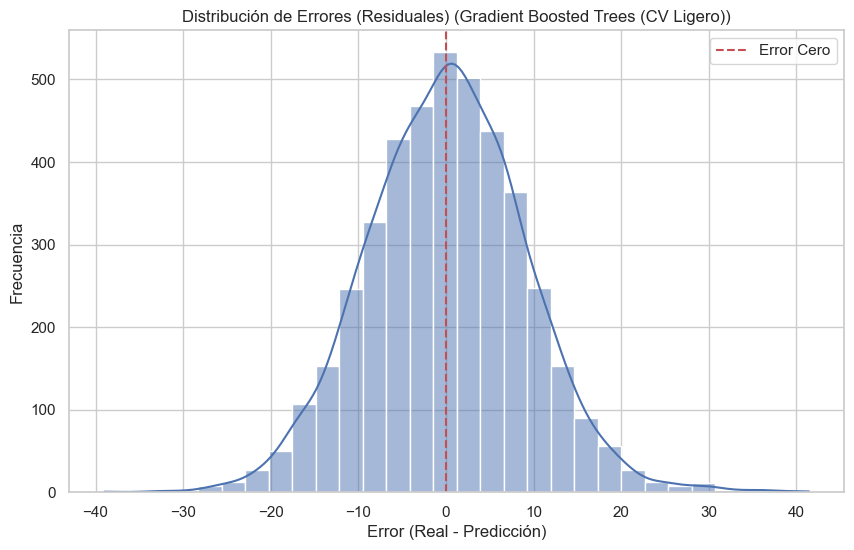

In [ ]:
import pyspark.sql.functions as F

print("="*70)
print(f"ANÁLISIS DE ERRORES: {best_model_name}")
print("="*70)

# Verificación de que las variables necesarias existen
if 'best_predictions_df' not in locals():
    print("ERROR: Debe ejecutar la celda de configuración del modelo primero.")
else:
    print(f"Analizando predicciones del modelo: {best_model_name}\n")

    # Cálculo de residuales (diferencia entre valor real y predicción)
    df_errores = best_predictions_df.withColumn('residual', F.col('label') - F.col('prediction'))

    # Tomo una muestra del 10% para análisis visual eficiente
    # Esto evita problemas de memoria al convertir a Pandas
    print("Extrayendo muestra aleatoria (10%) para análisis visual...")
    df_errores_pd = df_errores.select('label', 'prediction', 'residual').sample(0.1, seed=42).toPandas()
    print(f"Muestra extraída: {len(df_errores_pd):,} observaciones")

    # GRÁFICA 1: Predicción vs Valor Real
    # Esta gráfica permite evaluar la calidad general de las predicciones
    print("\nGenerando gráfica 1: Predicción vs Valor Real...")
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df_errores_pd, x='label', y='prediction', alpha=0.5)
    
    # Línea de predicción perfecta (y = x)
    max_val = max(df_errores_pd['label'].max(), df_errores_pd['prediction'].max())
    min_val = min(df_errores_pd['label'].min(), df_errores_pd['prediction'].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
    
    plt.title(f'Análisis de Calidad de Predicciones\n{best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Puntaje Real (observado)', fontsize=12)
    plt.ylabel('Puntaje Predicho (modelo)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('analisis_prediccion_vs_real.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nANÁLISIS DE LA GRÁFICA PREDICCIÓN VS REAL:")
    print("Los puntos cercanos a la línea roja diagonal indican predicciones precisas.")
    print("Dispersión vertical: indica variabilidad en las predicciones para un valor real dado.")
    print("Desviaciones sistemáticas de la diagonal sugieren sesgo en las predicciones.")

    # GRÁFICA 2: Distribución de Residuales
    # Esta gráfica evalúa si los errores siguen un patrón o son aleatorios
    print("\nGenerando gráfica 2: Distribución de Residuales...")
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_errores_pd, x='residual', kde=True, bins=50)
    plt.axvline(0, color='r', linestyle='--', linewidth=2, label='Error Cero')
    plt.title(f'Distribución de Errores de Predicción\n{best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Error (Real - Predicción)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('analisis_distribucion_errores.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nANÁLISIS DE LA DISTRIBUCIÓN DE ERRORES:")
    print("Una distribución centrada en cero indica ausencia de sesgo sistemático.")
    print("Forma de campana (normal): sugiere que el modelo captura bien los patrones principales.")
    print("Colas pesadas o asimetría: indican que ciertos casos son sistemáticamente mal predichos.")

    # Estadísticas descriptivas de los residuales
    print("\n" + "="*70)
    print("ESTADÍSTICAS DE LOS RESIDUALES:")
    print("="*70)
    print(f"Media de errores: {df_errores_pd['residual'].mean():.4f}")
    print(f"Mediana de errores: {df_errores_pd['residual'].median():.4f}")
    print(f"Desviación estándar: {df_errores_pd['residual'].std():.4f}")
    print(f"Error mínimo: {df_errores_pd['residual'].min():.4f}")
    print(f"Error máximo: {df_errores_pd['residual'].max():.4f}")
    
    print("\n" + "="*70)
    print("GRÁFICAS DE ANÁLISIS DE ERRORES GUARDADAS:")
    print("="*70)
    print("   1. analisis_prediccion_vs_real.png")
    print("   2. analisis_distribucion_errores.png")
    print("="*70)